In [3]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

# --- הגדרת המכשיר (GPU/CPU) ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on device: {device}")

# --- רשימת התיקיות לעיבוד (הוסף או הסר מכאן שמות לפי הצורך) ---
input_folders_list = [
    "experiments/background_drone_exp/data/images/clear_sky",
    "experiments/background_drone_exp/data/images/synthetic_buildings",
    "experiments/background_drone_exp/data/images/real_buildings"
]

# תיקיית העל לכל התוצאות
base_output_dir = "experiments/background_drone_exp/outputs/unified_results"
os.makedirs(base_output_dir, exist_ok=True)

print(f"Output will be saved to: {base_output_dir}")
print(f"Folders to process: {input_folders_list}")

c:\Users\MAOZD\OneDrive\מסמכים\שולחן העבודה\drone_background_exp\venv_sky_test\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on device: cpu
Output will be saved to: outputs/unified_results
Folders to process: ['data/images/clear_sky', 'data/images/synthetic_buildings', 'data/images/real_buildings']


In [ ]:
models = {}
print("Loading models... This may take a moment.")

# --- 1.Depth Anything V2 ---
try:
    print("⏳ Loading Depth Anything V2...")
    da_checkpoint = "depth-anything/Depth-Anything-V2-Small-hf" 
    da_processor = AutoImageProcessor.from_pretrained(da_checkpoint)
    da_model = AutoModelForDepthEstimation.from_pretrained(da_checkpoint).to(device)
    models['DepthAnything'] = (da_model, da_processor)
    print(" Depth Anything loaded.")
except Exception as e:
    print(f"❌ Error loading Depth Anything: {e}")

# --- 2. טעינת MiDaS BEiT ---
try:
    print("⏳ Loading MiDaS BEiT...")
    midas = torch.hub.load("intel-isl/MiDaS", "DPT_BEiT_L_512", trust_repo=True).to(device)
    midas.eval()
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms", trust_repo=True).dpt_transform
    models['MiDaS_BEiT'] = (midas, midas_transforms)
    print("✅ MiDaS loaded.")
except Exception as e:
    print(f"❌ Error loading MiDaS: {e}")

# --- 3. טעינת ZoeDepth (K & N) ---
for zoe_type in ["ZoeD_K", "ZoeD_N"]:
    try:
        print(f"⏳ Loading {zoe_type}...")
        zoe = torch.hub.load("isl-org/ZoeDepth", zoe_type, pretrained=True, trust_repo=True).to(device)
        zoe.eval()
        models[zoe_type] = zoe
        print(f"✅ {zoe_type} loaded.")
    except Exception as e:
        print(f"❌ Error loading {zoe_type}: {e}")

print("\n🎉 All models are ready!")

Loading models... This may take a moment.
⏳ Loading Depth Anything V2...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✅ Depth Anything loaded.
⏳ Loading MiDaS BEiT...


Using cache found in C:\Users\MAOZD/.cache\torch\hub\intel-isl_MiDaS_master
c:\Users\MAOZD\OneDrive\מסמכים\שולחן העבודה\drone_background_exp\venv_sky_test\Lib\site-packages\torch\functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4319.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Using cache found in C:\Users\MAOZD/.cache\torch\hub\intel-isl_MiDaS_master


✅ MiDaS loaded.
⏳ Loading ZoeD_K...


Using cache found in C:\Users\MAOZD/.cache\torch\hub\isl-org_ZoeDepth_main


Overwriting config with config_version kitti
img_size [384, 768]


Using cache found in C:\Users\MAOZD/.cache\torch\hub\intel-isl_MiDaS_master


Params passed to Resize transform:
	width:  768
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_K.pt
Loaded successfully
✅ ZoeD_K loaded.
⏳ Loading ZoeD_N...


Using cache found in C:\Users\MAOZD/.cache\torch\hub\isl-org_ZoeDepth_main
Using cache found in C:\Users\MAOZD/.cache\torch\hub\intel-isl_MiDaS_master


img_size [384, 512]
Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Loaded successfully
✅ ZoeD_N loaded.

🎉 All models are ready!


In [5]:
# --- Cell 3A: Common Setup & Definitions ---
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# רשימת התיקיות לעיבוד
input_folders_list = [
    "experiments/background_drone_exp/data/images/clear_sky",
    "experiments/background_drone_exp/data/images/synthetic_buildings",
    "experiments/background_drone_exp/data/images/real_buildings"
]

base_output_dir = "experiments/background_drone_exp/outputs/unified_results"
os.makedirs(base_output_dir, exist_ok=True)

# פונקציית נירמול
def normalize_output(depth_map):
    d_min = depth_map.min()
    d_max = depth_map.max()
    if d_max - d_min > 1e-6:
        normalized = (depth_map - d_min) / (d_max - d_min)
    else:
        normalized = np.zeros_like(depth_map)
    return (normalized * 255).astype("uint8")

print("✅ Setup Complete. Output directory ready.")

✅ Setup Complete. Output directory ready.


In [4]:
# --- Cell 3B: EXECUTE Depth Anything Only ---
import torch

if 'models' in globals() and 'DepthAnything' in models:
    print("🚀 Starting Depth Anything Execution...")
    da_model, da_processor = models['DepthAnything']
    
    for folder in input_folders_list:
        print(f"  📂 Processing folder: {folder}")
        
        # יצירת נתיב שמירה
        save_dir = os.path.join(base_output_dir, folder, "depth_anything")
        os.makedirs(save_dir, exist_ok=True)
        
        files = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        for filename in files:
            img_path = os.path.join(folder, filename)
            try:
                pil_img = Image.open(img_path).convert("RGB")
                
                # עיבוד
                inputs = da_processor(images=pil_img, return_tensors="pt").to(device)
                with torch.no_grad():
                    out = da_model(**inputs)
                    pred = torch.nn.functional.interpolate(
                        out.predicted_depth.unsqueeze(1),
                        size=pil_img.size[::-1],
                        mode="bicubic",
                        align_corners=False,
                    )
                    
                # שמירה
                output_norm = normalize_output(pred.squeeze().cpu().numpy())
                colored = cv2.applyColorMap(output_norm, cv2.COLORMAP_INFERNO)
                cv2.imwrite(os.path.join(save_dir, filename), colored)
                
            except Exception as e:
                print(f"    ❌ Error on {filename}: {e}")
                
    print("✅ Depth Anything finished for all folders!")
    
    # ניקוי זיכרון אופציונלי
    torch.cuda.empty_cache()
else:
    print("⚠️ Depth Anything model not loaded! Run the loading cell first.")

🚀 Starting Depth Anything Execution...
  📂 Processing folder: data/images/clear_sky
  📂 Processing folder: data/images/synthetic_buildings
  📂 Processing folder: data/images/real_buildings
✅ Depth Anything finished for all folders!


In [5]:
# --- Cell 3C: EXECUTE MiDaS Only ---
if 'models' in globals() and 'MiDaS_BEiT' in models:
    print("🚀 Starting MiDaS Execution...")
    midas_model, midas_trans = models['MiDaS_BEiT']
    
    for folder in input_folders_list:
        print(f"  📂 Processing folder: {folder}")
        
        save_dir = os.path.join(base_output_dir, folder, "midas_beit")
        os.makedirs(save_dir, exist_ok=True)
        
        files = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        for filename in files:
            img_path = os.path.join(folder, filename)
            try:
                cv_img = cv2.imread(img_path)
                cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
                
                # עיבוד
                inp = midas_trans(cv_img).to(device)
                with torch.no_grad():
                    pred = midas_model(inp)
                    pred = torch.nn.functional.interpolate(
                        pred.unsqueeze(1),
                        size=cv_img.shape[:2],
                        mode="bicubic",
                        align_corners=False,
                    )
                
                # שמירה
                output_norm = normalize_output(pred.squeeze().cpu().numpy())
                colored = cv2.applyColorMap(output_norm, cv2.COLORMAP_INFERNO)
                cv2.imwrite(os.path.join(save_dir, filename), colored)
                
            except Exception as e:
                print(f"    ❌ Error on {filename}: {e}")

    print("✅ MiDaS finished for all folders!")
    torch.cuda.empty_cache()
else:
    print("⚠️ MiDaS model not loaded! Run the loading cell first.")

🚀 Starting MiDaS Execution...
  📂 Processing folder: data/images/clear_sky
  📂 Processing folder: data/images/synthetic_buildings
  📂 Processing folder: data/images/real_buildings
✅ MiDaS finished for all folders!


In [6]:
# --- Cell 3D: EXECUTE ZoeDepth Only ---
zoe_keys = [k for k in ['ZoeD_K', 'ZoeD_N'] if 'models' in globals() and k in models]

if zoe_keys:
    print(f"🚀 Starting ZoeDepth Execution ({zoe_keys})...")
    
    for folder in input_folders_list:
        print(f"  📂 Processing folder: {folder}")
        
        files = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        for z_key in zoe_keys:
            # יצירת תיקייה לכל סוג (K או N)
            sub_name = "zoe_k" if "K" in z_key else "zoe_n"
            save_dir = os.path.join(base_output_dir, folder, sub_name)
            os.makedirs(save_dir, exist_ok=True)
            
            model = models[z_key]
            
            for filename in files:
                img_path = os.path.join(folder, filename)
                try:
                    pil_img = Image.open(img_path).convert("RGB")
                    
                    with torch.no_grad():
                        pred = model.infer_pil(pil_img)
                        
                    output_norm = normalize_output(pred)
                    colored = cv2.applyColorMap(output_norm, cv2.COLORMAP_INFERNO)
                    cv2.imwrite(os.path.join(save_dir, filename), colored)
                    
                except Exception as e:
                    print(f"    ❌ Error on {filename}: {e}")
                    
    print("✅ ZoeDepth finished for all folders!")
    torch.cuda.empty_cache()
else:
    print("⚠️ No ZoeDepth models loaded! Run the loading cell first.")

🚀 Starting ZoeDepth Execution (['ZoeD_K', 'ZoeD_N'])...
  📂 Processing folder: data/images/clear_sky
  📂 Processing folder: data/images/synthetic_buildings
  📂 Processing folder: data/images/real_buildings


: 

In [2]:
# --- Cell 4: Generate Comparison Plots (From Saved Results) ---
print("📊 Generating Comparison Plots...")

for folder in input_folders_list:
    print(f"  📂 Generating for: {folder}")
    
    folder_out_base = os.path.join(base_output_dir, folder)
    if not os.path.exists(folder_out_base): continue
    
    # נתיבים לתוצאות שנשמרו
    paths = {
        "DepthAnything": os.path.join(folder_out_base, "depth_anything"),
        "MiDaS_BEiT": os.path.join(folder_out_base, "midas_beit"),
        "ZoeD_N": os.path.join(folder_out_base, "zoe_n"),
        "ZoeD_K": os.path.join(folder_out_base, "zoe_k")
    }
    
    files = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for filename in files:
        # פתיחת תמונה מקורית
        orig_path = os.path.join(folder, filename)
        if not os.path.exists(orig_path): continue
        orig_img = Image.open(orig_path).convert("RGB")
        
        # יצירת הפלוט
        plt.figure(figsize=(25, 5))
        
        # 1. מקור
        plt.subplot(1, 5, 1)
        plt.imshow(orig_img)
        plt.title(f"Original: {filename}", fontsize=9)
        plt.axis("off")
        
        # 2-5. תוצאות
        idx = 2
        for name in ['DepthAnything', 'MiDaS_BEiT', 'ZoeD_N', 'ZoeD_K']:
            res_path = os.path.join(paths[name], filename)
            
            if os.path.exists(res_path):
                # קריאת התמונה הצבעונית שנשמרה
                res_img = Image.open(res_path)
                plt.subplot(1, 5, idx)
                plt.imshow(res_img)
                plt.title(name, fontsize=10)
                plt.axis("off")
            else:
                # אם המודל לא הורץ, נשאיר ריק או נכתוב הודעה
                plt.subplot(1, 5, idx)
                plt.text(0.5, 0.5, "Not Run", ha='center', va='center')
                plt.title(name, fontsize=10)
                plt.axis("off")
                
            idx += 1
            
        # שמירת ההשוואה
        plt.savefig(os.path.join(folder_out_base, f"COMPARE_{filename}"), bbox_inches='tight')
        plt.close()

print("🏁 All comparison plots generated successfully!")

📊 Generating Comparison Plots...


NameError: name 'input_folders_list' is not defined

# Depth Estimation Analysis: Drones in Aerial Environments

This document summarizes the performance of three depth estimation models tested on images of drones in various sky environments:
1.  **ZoeDepth K (Outdoor)**: Metric depth estimation trained on outdoor scenes (KITTI).
2.  **ZoeDepth N (Indoor)**: Metric depth estimation trained on indoor scenes (NYU Depth V2).
3.  **MiDaS BEiT (Relative)**: Relative depth estimation using a vision transformer backbone.

---

## 1. Individual Image Analysis

### Case 1: Close Range, Clear Sky (`drone1.png`)
* **Observations:**
    * **ZoeDepth (K & N):** Both models identify the object's presence but produce a "blurry" result. The drone appears as an amorphous blob; arms and propellers are lost.
    * **MiDaS:** Excellent performance. It captures the sharp contours of the drone, including the landing gear and arms, creating a distinct separation from the background.
* **Hypothesis:** MiDaS relies on relative depth and excels at foreground-background segmentation. ZoeDepth attempts to calculate metric distance, and without texture on the drone or background, it smooths out the details to minimize error.

### Case 2: Angled View, Clear Sky (`drone2.png`)
* **Observations:**
    * **ZoeDepth K (Outdoor):** Significant failure. The model hallucinates artifacts in the clear sky, creating a noisy, patchy background. The drone is barely distinguishable.
    * **ZoeDepth N (Indoor):** Surprisingly good results. It generates a clean silhouette of the drone against a smooth background, performing significantly better than the Outdoor version.
    * **MiDaS:** Remains the most consistent, providing high contrast and sharp edge detection.
* **Hypothesis:** The "Outdoor" model expects ground textures (roads, trees, buildings). When faced with empty blue sky, it interprets noise as depth. The "Indoor" model is accustomed to smooth walls, which geometrically resemble the flat sky, leading to cleaner results.

### Case 3: Complex Background, Sunset (`drone3.png`)
* **Observations:**
    * **ZoeDepth K:** successfully detects the mountain range in the distance but fails to define the drone sharply.
    * **ZoeDepth N:** Creates a "halo" effect around the drone, making it appear thicker than it is. It struggles to differentiate the gradient of the sky from the mountains.
    * **MiDaS:** Superior separation. It clearly distinguishes three layers: the drone (brightest/closest), the mountains (mid-range), and the sky (darkest/furthest).
* **Hypothesis:** Relative depth models (MiDaS) are trained on diverse datasets with complex scenes, making them robust at understanding layer hierarchy (Foreground vs. Background) even with complex lighting.

### Case 4 & 5: Long Range / Clouds (`drone4.png`, `drone5.png`)
* **Observations:**
    * **Cloud Interference (`drone4`):** MiDaS confuses the clouds for structural objects, losing the small drone in the texture map.
    * **Extreme Distance (`drone5`):** All models fail. MiDaS exhibits "Central Bias" (predicting the center of the image is closer simply because it is the center), resulting in a meaningless blob. ZoeDepth K generates pure noise.
* **Hypothesis:** This is the **"Small Object Problem."** Depth models rely on context and semantic understanding. When an object occupies very few pixels, the model lacks the information to determine its depth and reverts to priors (like central bias) or noise.

---

## 2. Key Insights & Conclusions

### A. The "Relative" Advantage
**MiDaS is the clear winner for shape preservation.**
Because MiDaS calculates *relative* depth (ranking pixels from closest to furthest) rather than absolute meters, it acts almost like a high-quality segmentation mask. For obstacle avoidance where identifying the *edges* of the drone is critical, MiDaS is the superior choice.

### B. The "Indoor" Paradox
**ZoeDepth N (Indoor) outperforms ZoeDepth K (Outdoor) in sky scenarios.**
This is counter-intuitive but logical. Outdoor models are trained to find depth cues in ground textures and horizons. A clear sky confuses them. Indoor models are trained on rooms with flat, texture-less walls. To an indoor model, a clear blue sky looks like a "wall" at infinity, allowing it to isolate the drone (the "furniture") more effectively.

### C. Metric Unreliability
**Do not trust the absolute numbers.**
In a sky environment with no reference points (no ground plane), the metric values (meters) output by ZoeDepth are likely inaccurate. The models "float" the values because they lack scale cues.

### D. The Small Object Limitation
**Depth estimation is not a detector.**
For long-range drones (small dots), depth models are useless and can generate false positives (hallucinations).
* **Recommendation:** Use an Object Detector (like YOLO) to find the drone first. Only apply depth estimation when the bounding box size exceeds a certain threshold (indicating the drone is close enough for the depth data to be meaningful).

---

found 6 images with complex background. Starting analysis...

Processing: drone1.png...


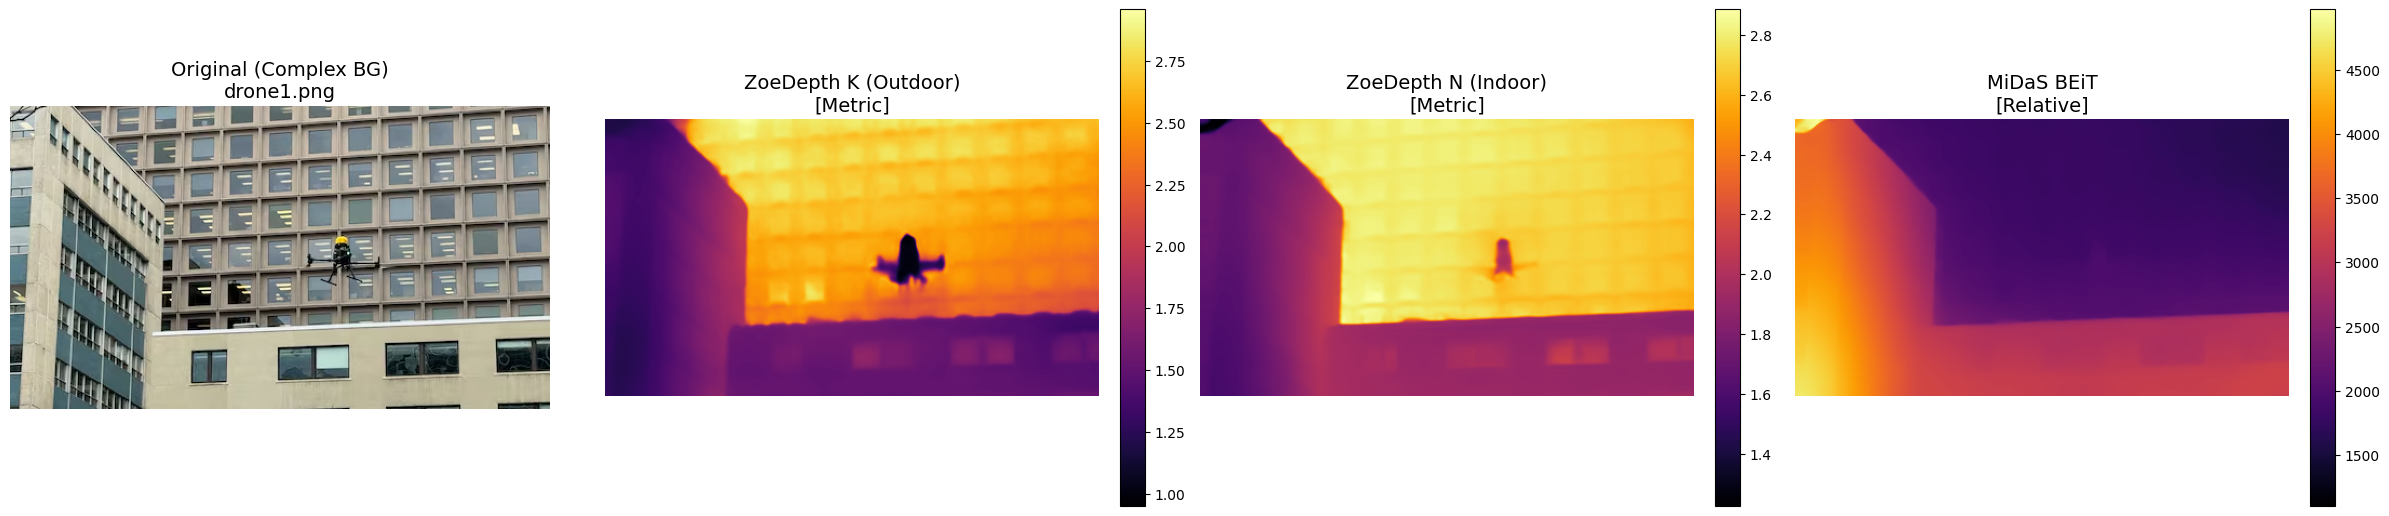


Processing: drone2.png...


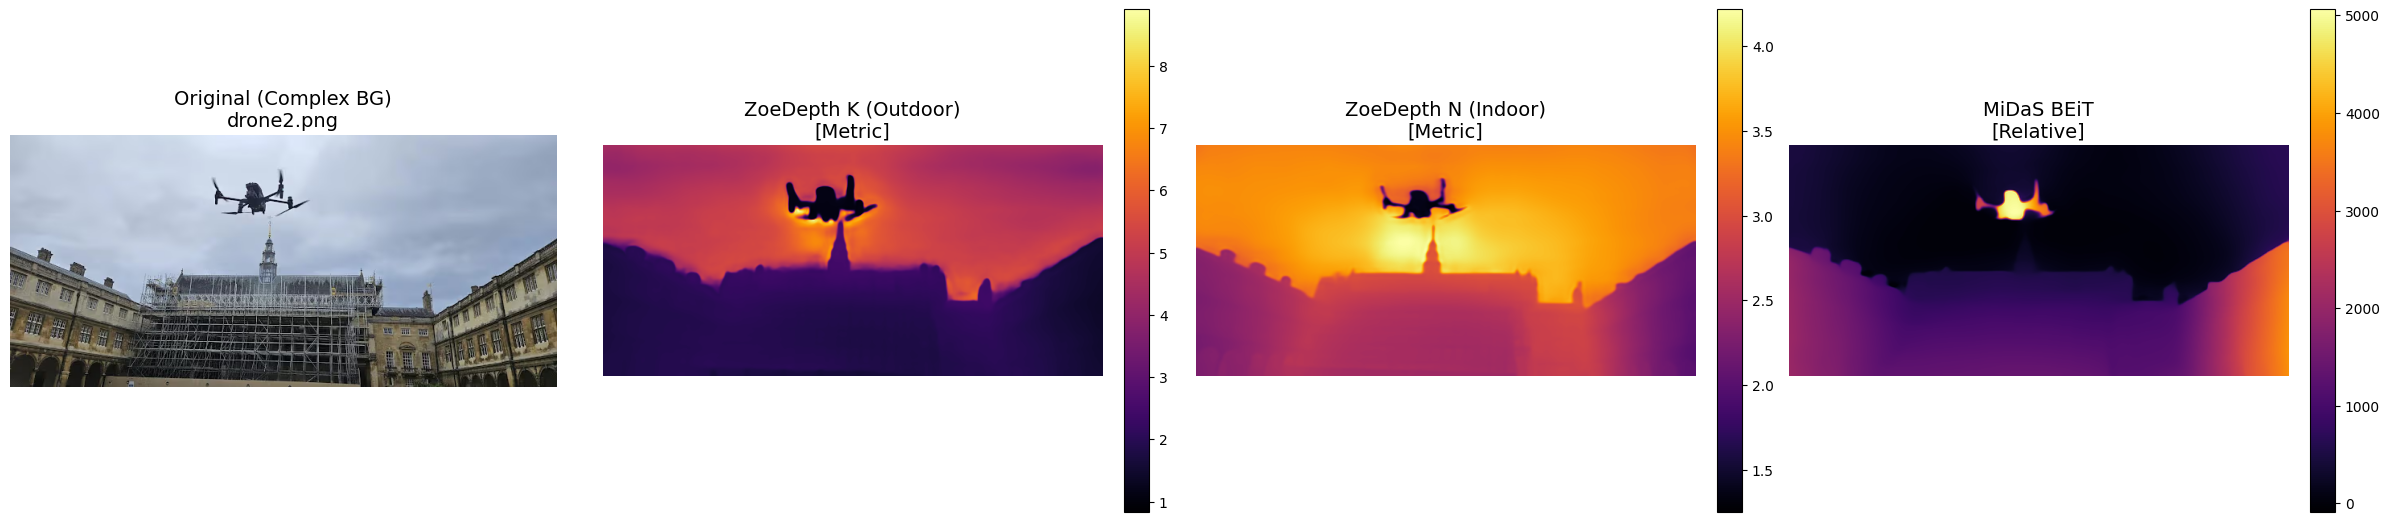


Processing: drone3.png...


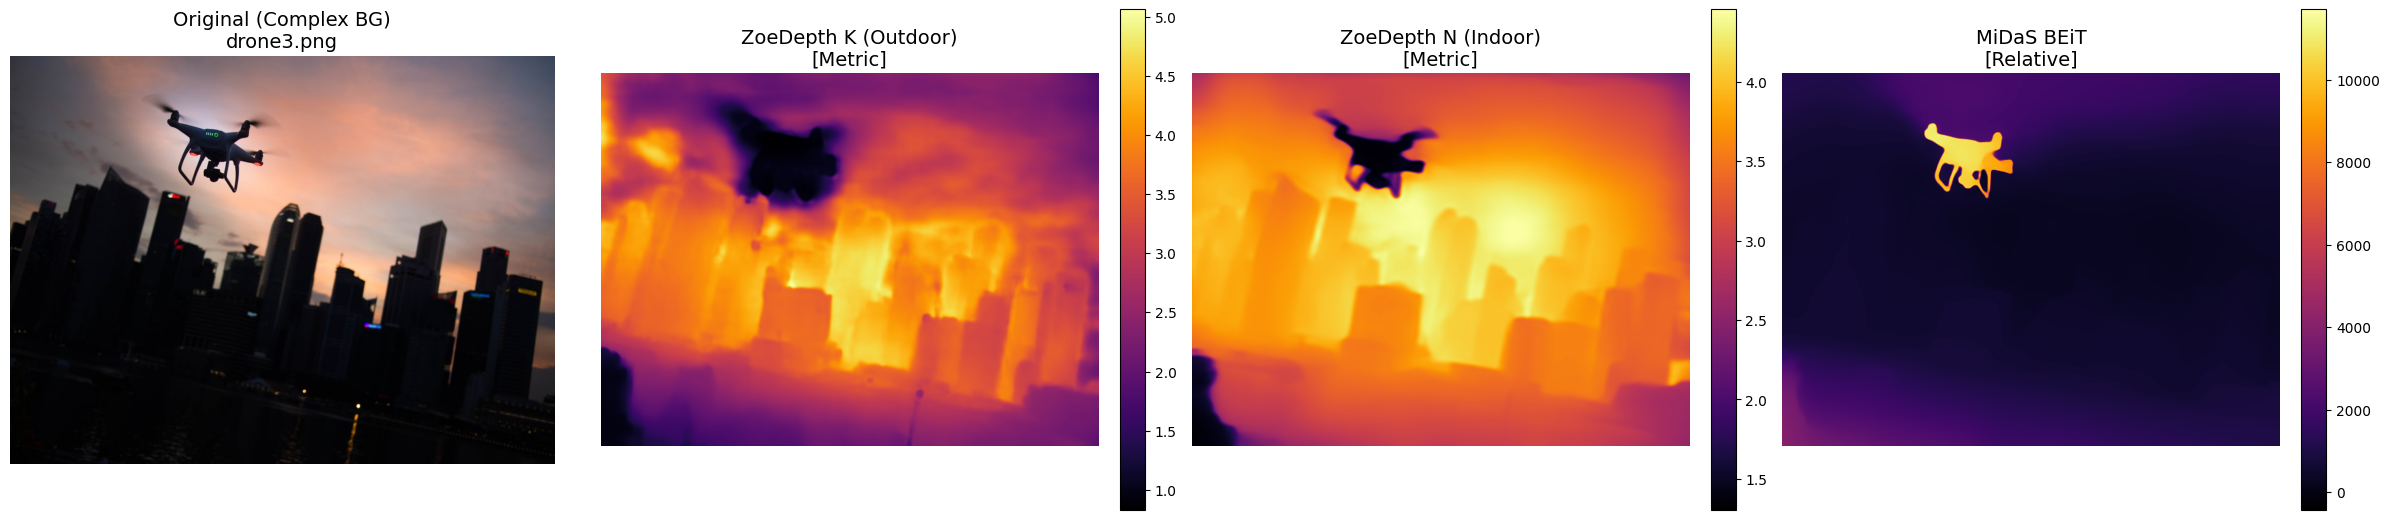


Processing: drone4.png...


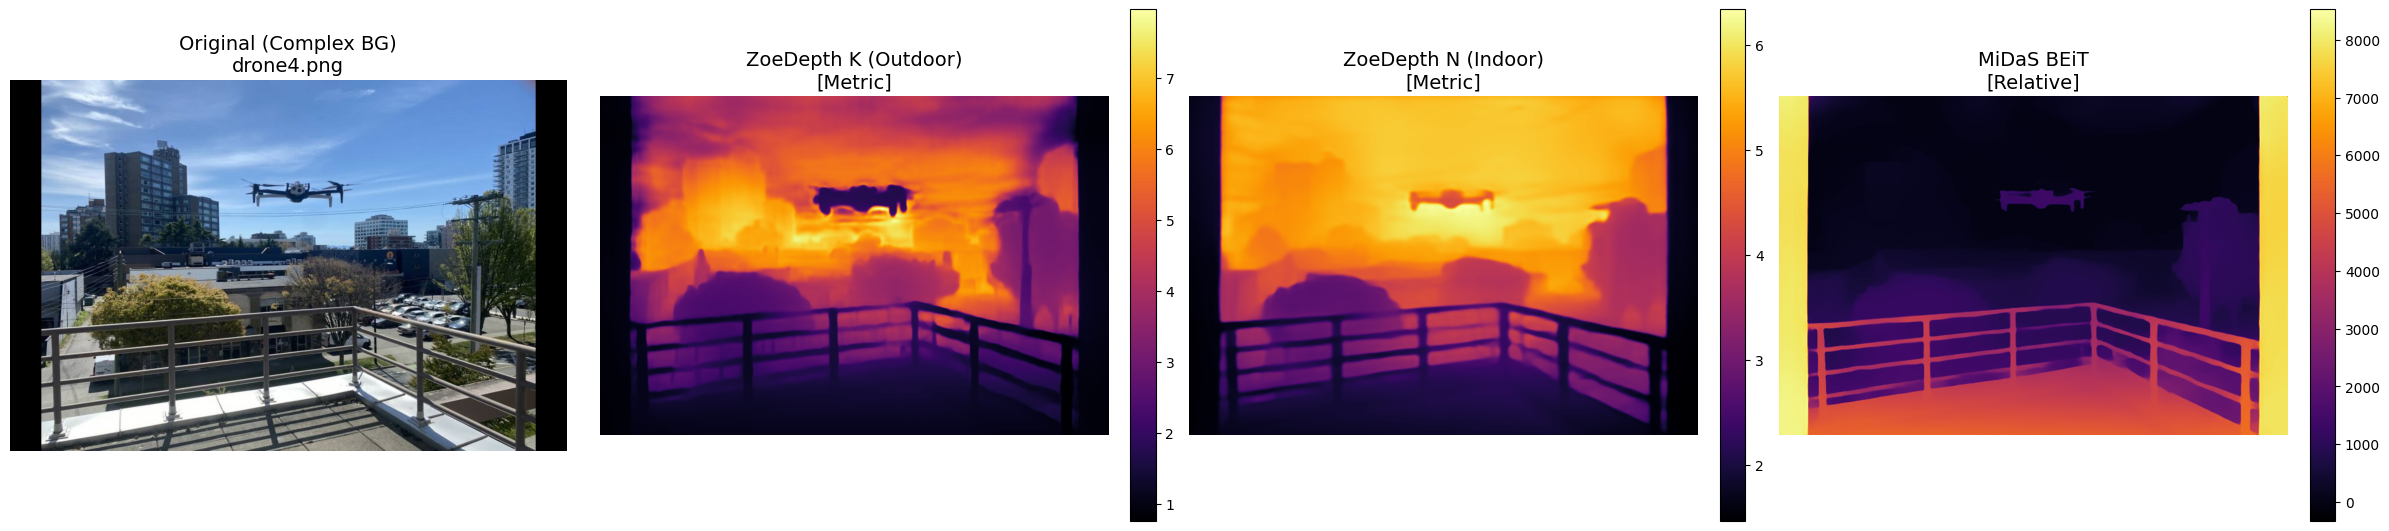


Processing: drone5.png...


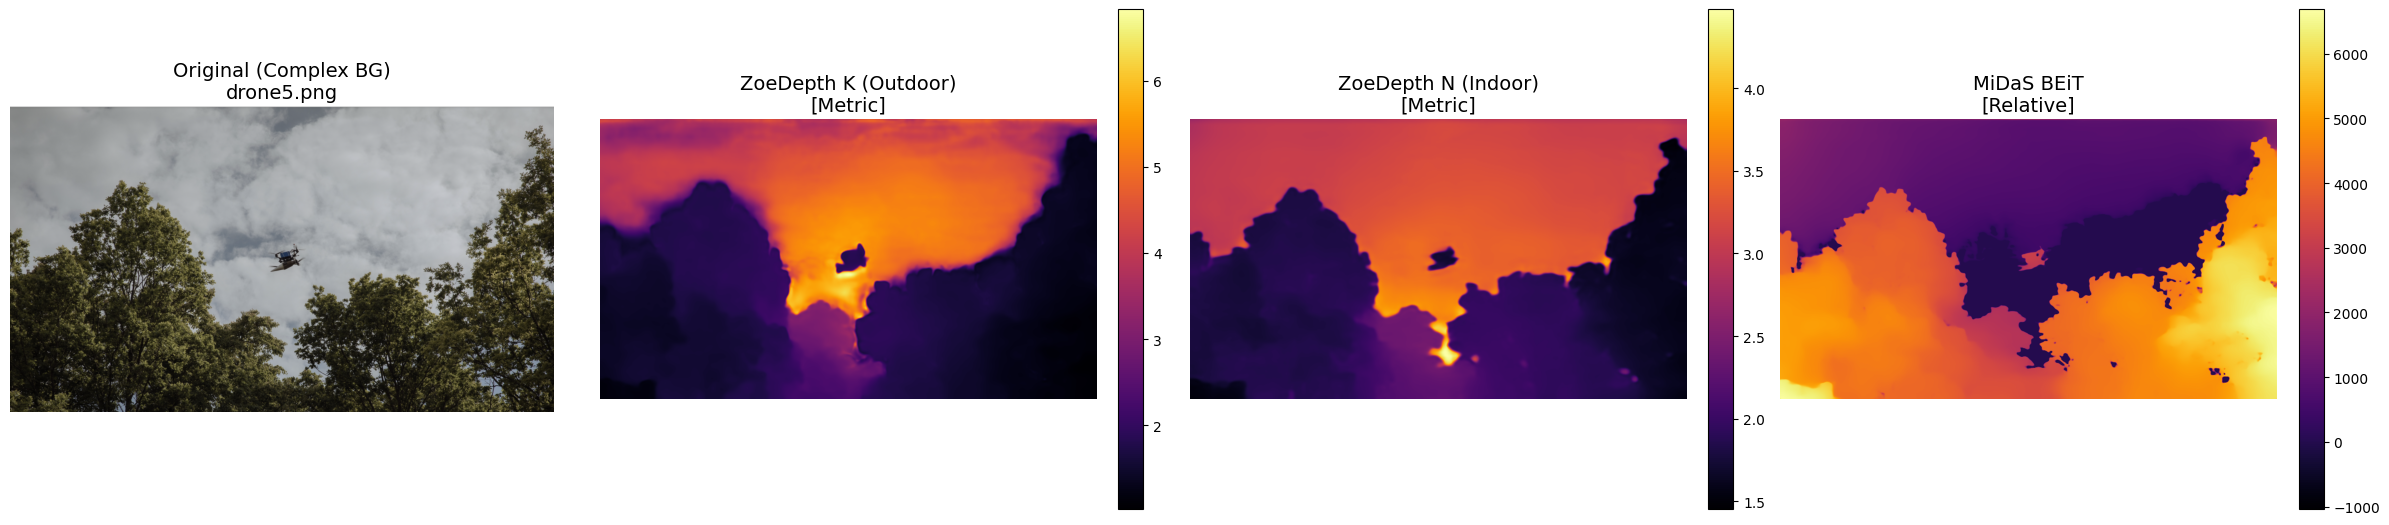


Processing: drone6.png...


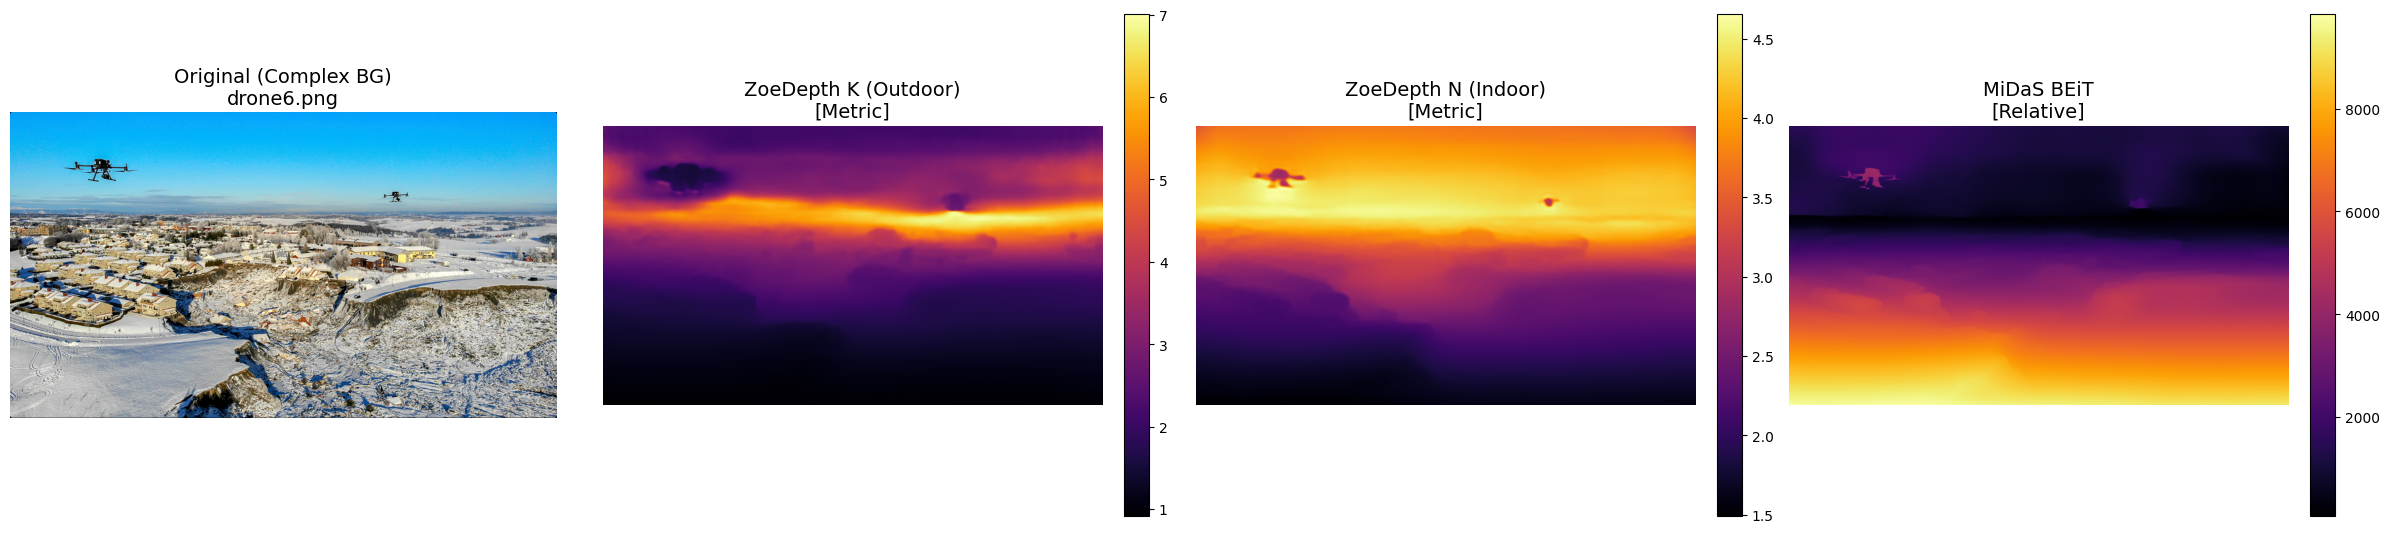


Done! Complex background analysis complete.


In [6]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- הגדרות נתיבים לניסוי החדש (רקע מורכב) ---
input_folder_complex = "experiments/background_drone_exp/data/images/synthetic_buildings" 
output_base_complex = "experiments/background_drone_exp/outputs/buildings" # תיקיית על לתוצאות החדשות

output_paths = {
    "ZoeD_K": os.path.join(output_base_complex, "ZoeD_K"),
    "ZoeD_N": os.path.join(output_base_complex, "ZoeD_N"),
    "MiDaS_BEiT": os.path.join(output_base_complex, "MiDaS_BEiT")
}

# יצירת תיקיות פלט
for path in output_paths.values():
    os.makedirs(path, exist_ok=True)

# קבלת רשימת התמונות
image_files = [f for f in os.listdir(input_folder_complex) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if not image_files:
    print(f"⚠️ Warning: No images found in '{input_folder_complex}'. Please check folder name.")
else:
    print(f"found {len(image_files)} images with complex background. Starting analysis...")

# --- לולאת העיבוד ---
for img_name in image_files:
    img_path = os.path.join(input_folder_complex, img_name)
    print(f"\nProcessing: {img_name}...")
    
    # טעינה
    try:
        img_pil = Image.open(img_path).convert("RGB")
        img_cv2 = np.array(img_pil)
    except Exception as e:
        print(f"Error loading image {img_name}: {e}")
        continue
    
    # 1. ZoeDepth K (Outdoor)
    with torch.no_grad():
        depth_k = model_zoe_k.infer_pil(img_pil)
    # שמירה
    plt.imsave(os.path.join(output_paths["ZoeD_K"], f"depth_{img_name}"), depth_k, cmap='inferno')
    
    # 2. ZoeDepth N (Indoor)
    with torch.no_grad():
        depth_n = model_zoe_n.infer_pil(img_pil)
    # שמירה
    plt.imsave(os.path.join(output_paths["ZoeD_N"], f"depth_{img_name}"), depth_n, cmap='inferno')
        
    # 3. MiDaS BEiT
    # שימוש בפונקציית העזר שהגדרנו קודם (run_midas)
    # מוודאים שהיא קיימת, אם לא - מגדירים אותה מחדש מקומית ליתר ביטחון
    if 'run_midas' not in locals() and 'run_midas' not in globals():
        print("Function 'run_midas' missing, skipping MiDaS display for safety.")
        depth_midas = np.zeros_like(depth_k)
    else:
        depth_midas = run_midas(img_cv2, img_pil.size[::-1]) # (H,W) size from (W,H) PIL size? No, PIL size is (W,H), shape needs (H,W).
        # תיקון קטן: ב-run_midas שהגדרנו קודם, הפונקציה מצפה ל-shape (H,W)
        # אז נעביר את img_cv2.shape[:2] שזה (H,W)
        depth_midas = run_midas(img_cv2, img_cv2.shape[:2])

    # שמירה
    plt.imsave(os.path.join(output_paths["MiDaS_BEiT"], f"depth_{img_name}"), depth_midas, cmap='inferno')

    # --- ויזואליזציה ---
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    
    # מקור
    axes[0].imshow(img_pil)
    axes[0].set_title(f"Original (Complex BG)\n{img_name}", fontsize=14)
    axes[0].axis('off')
    
    # Zoe K
    im1 = axes[1].imshow(depth_k, cmap='inferno')
    axes[1].set_title("ZoeDepth K (Outdoor)\n[Metric]", fontsize=14)
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    
    # Zoe N
    im2 = axes[2].imshow(depth_n, cmap='inferno')
    axes[2].set_title("ZoeDepth N (Indoor)\n[Metric]", fontsize=14)
    axes[2].axis('off')
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    # MiDaS
    im3 = axes[3].imshow(depth_midas, cmap='inferno')
    axes[3].set_title("MiDaS BEiT\n[Relative]", fontsize=14)
    axes[3].axis('off')
    plt.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

print("\nDone! Complex background analysis complete.")

# Monocular Depth Estimation for UAV Detection: Comprehensive Analysis

## 1. Introduction & Executive Summary
This report evaluates the performance of three state-of-the-art depth estimation models for the specific task of identifying drones (UAVs) across diverse aerial environments.

**Models Tested:**
1.  **ZoeDepth K (Outdoor):** Metric depth estimation (KITTI trained).
2.  **ZoeDepth N (Indoor):** Metric depth estimation (NYU Depth V2 trained).
3.  **MiDaS BEiT (Relative):** Relative depth estimation (Vision Transformer).

**General Conclusion:**
No single model is perfect for all scenarios. **MiDaS** is superior for shape definition and relative positioning in open spaces, while **ZoeDepth K** is essential for detecting drones against complex, textured vertical surfaces (walls).

---

## 2. Environment Analysis

### A. The "Clean Sky" Scenario
* **Context:** Drone flying against blue sky, clouds, or sunset.
* **Winner:** **MiDaS BEiT**.
* **Analysis:** MiDaS treats the sky as an infinite background, forcing the drone (the only salient object) to the foreground. It preserves geometric details like propellers and landing gear.
* **Failure Mode:** **ZoeDepth K** tends to "hallucinate" noise in empty skies or blur the drone into an amorphous blob.

### B. The "Urban" Scenarios (The Distance Rule)
Performance in cities depends entirely on the distance between the drone and the background.

#### B1. The "Close Wall" Problem (Camouflage)
* **Context:** Drone flying close to a building facade with repetitive textures (windows).
* **Winner:** **ZoeDepth K (Outdoor)**.
* **Analysis:** **MiDaS fails here.** The strong texture of the windows and the proximity of the wall cause the drone to blend in (camouflage). **ZoeDepth K**, trained on cityscapes, correctly identifies the drone as a physical obstacle distinct from the wall.

#### B2. The "Distant Skyline" Advantage (Silhouette)
* **Context:** Drone flying against a distant city skyline.
* **Winner:** **MiDaS BEiT**.
* **Analysis:** Because the buildings are far away, they act as a "backdrop." MiDaS easily separates the foreground (drone) from the background (city), providing a sharp, high-contrast silhouette.

#### B3. Foreground Clutter
* **Context:** Drone behind or near a railing/balcony.
* **Winner:** **MiDaS BEiT**.
* **Analysis:** MiDaS successfully builds a hierarchy: *Railing (Closest) > Drone (Close) > Background (Far)*. This is critical for safe landing operations.

### C. The "Nature" Scenario (Trees & Snow)
* **Context:** Drone flying over snow or near trees.
* **Observation:** The "Saliency Competition."
* **Analysis:** In these images, large environmental features (snowy ground, large trees) often dominate the depth map.
    * **MiDaS** highlights the trees as the primary obstacle, often ignoring a small drone in the distance.
    * **ZoeDepth K** provides a good "No-Fly Zone" map (identifying ground and tree lines) but fails to resolve the drone itself.

---

## 3. Universal Failure Mode: "The Small Object Problem"
Across all models, if the drone occupies less than **1-2% of the frame** (long-range), depth estimation is unreliable.
* **MiDaS:** Suffers from "Central Bias" (predicting the center is close regardless of content).
* **ZoeDepth:** Outputs noise.

---

## 4. Practical Guide: Which Model to Use?

This "Decision Matrix" defines the logic for your autonomous system.

### The "Hybrid Pipeline" Logic

**Do not rely on depth maps for detection.** Always use an Object Detector (e.g., YOLO) first to find the Bounding Box (BBox). Then, analyze the content *inside* the BBox to choose the depth model.

# Generic Decision Matrix for Monocular Depth Estimation

This matrix generalizes the findings from specific scenarios (sky, buildings, nature) into visual computing principles for autonomous decision-making.

| Environment Context | Visual Cue (Inside BBox) | **Recommended Model** | **Why?** |
| :--- | :--- | :--- | :--- |
| **Uniform / Low Texture** | Smooth, consistent colors with no patterns (e.g., Clear Sky, Plain Wall). | **MiDaS BEiT** | Best at isolating the only "salient" object against a void or smooth surface. |
| **Distant Background** | Background exists but is far away (High Depth Delta), creating a silhouette effect (e.g., Skyline, Distant Landscape). | **MiDaS BEiT** | Excellent at separating layers (Foreground vs. Deep Background), regardless of background texture. |
| **Textured & Close** | Repetitive patterns immediately behind the object (e.g., Windows, Bricks, Dense Foliage). | **ZoeDepth K (Outdoor)** | MiDaS fails due to "Camouflage" (blends object into texture). ZoeDepth detects the physical protrusion/obstacle. |
| **Long Range** | Object size is tiny (< 1-2% of the frame). | **NONE** | **Do not use depth.** Models produce noise or bias. Rely solely on YOLO bounding box size for distance estimation. |

### Distance Calculation Formula
Since "Metric Depth" in air is unreliable (scale ambiguity), use the geometric approach:

1.  **Detect:** Get BBox width in pixels ($W_{px}$).
2.  **Identify:** Know the drone model (e.g., DJI Phantom width $W_{real} \approx 350mm$).
3.  **Calculate:**
    $$Distance = \frac{W_{real} \times FocalLength}{W_{px}}$$